In [1]:
# cloning the github repo

!git clone https://github.com/arjun-k8/Object-classification-using-cnn-basketball.git

Cloning into 'Object-classification-using-cnn-basketball'...
remote: Enumerating objects: 546, done.
remote: Total 546 (delta 0), reused 0 (delta 0), pack-reused 546
Receiving objects: 100% (546/546), 190.80 MiB | 26.01 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [2]:
# listing files in the repo
!ls Object-classification-using-cnn-basketball

dataset  README.md


In [3]:
# importing libraries

import pandas as pd
import numpy as np
import os
from os import listdir
from glob import glob
import itertools
import fnmatch
import random
from PIL import Image
import zlib
import itertools
import csv
import math
from tqdm import tqdm
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import skimage
from skimage import transform
from skimage.transform import resize
import scipy
from scipy import misc
import keras
from keras import backend as K
from keras import models, layers, optimizers
from keras.models import Model, Sequential, model_from_json
from keras.layers import Dense, Dropout, Input, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, Lambda, AveragePooling2D
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score,classification_report
from sklearn.utils import class_weight
%matplotlib inline

In [4]:
# set path of dataset

path ='Object-classification-using-cnn-basketball/dataset/'

In [5]:
# loading the images and setting catagories

def loadBatchImages(path):
    catList = listdir(path)
    loadedImagesTrain = []
    loadedLabelsTrain = []
    loadedImagesVal = []
    loadedLabelsVal = []
    for cat in catList:
        deepPath = path+cat+"/"
        imageList = listdir(deepPath)
        for images in imageList:                
            img = cv2.imread(deepPath + images)
            img = cv2.resize(img, (224,224))
            loadedLabelsTrain.append(int(cat))
            loadedImagesTrain.append(img)
    return loadedImagesTrain,to_categorical(loadedLabelsTrain)

In [6]:
# spliting data to tain, test, val

def shuffledSet(a, b, test_proportion=0.2, val_proportion=0.2):
    assert np.shape(a)[0] == np.shape(b)[0]
    p = np.random.permutation(np.shape(a)[0])
    num_test = math.ceil(len(p)* test_proportion)
    num_val = math.ceil(len(p) * val_proportion)
    s1 = p[num_test + num_val:]
    s2 = p[num_test: num_test + num_val]
    s3 = p[0:num_test]
    return (a[s1], b[s1]), (a[s2], b[s2]), (a[s3], b[s3])

In [7]:
data, labels = loadBatchImages(path)

In [8]:
train, val, test = shuffledSet(np.asarray(data),labels,0.2,0.1)

In [9]:
X_train, y_train = train[0], train[1]
X_val, y_val = val[0], val[1]
X_test, y_test = test[0],test[1]

In [10]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(264, 224, 224, 3)
(76, 224, 224, 3)
(38, 224, 224, 3)


In [11]:
# checking shapes of datasets.

assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (224, 224, 3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (224, 224, 3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (224, 224, 3)), "The dimensions of the images are not 32 x 32 x 3."

In [12]:
# display a matrix of sample images

def plotThreeImages(iclass, row, col):
    images = glob('{}{}/**'.format(path, str(iclass)))
    plt.figure(figsize=(10,10))
    r = random.sample(images, row*col)
    for i in range(1, (row*col)+1):
        plt.subplot(row, col, i)
        plt.imshow(cv2.cvtColor(cv2.imread(r[i-1]), cv2.COLOR_BGR2RGB))
        plt.axis('off')

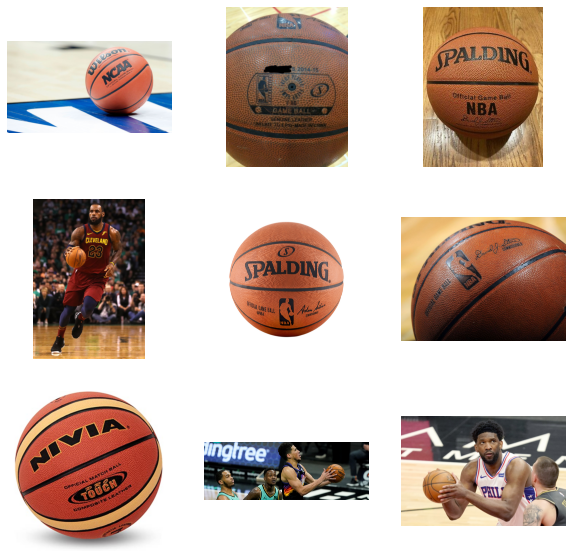

In [13]:
plotThreeImages(1,3,3)

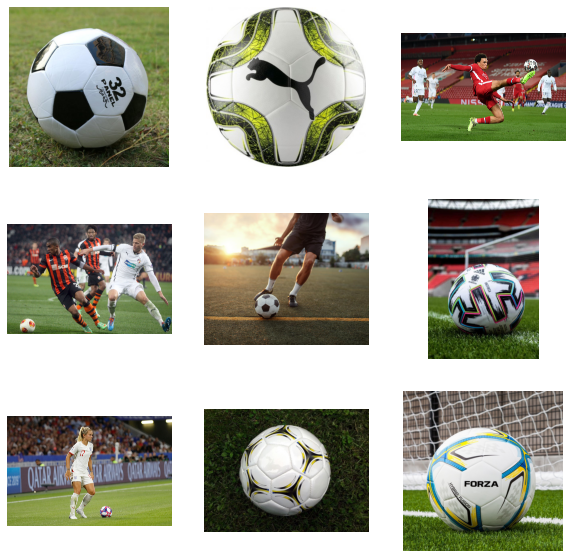

In [14]:
plotThreeImages(0,3,3)

[152, 112]


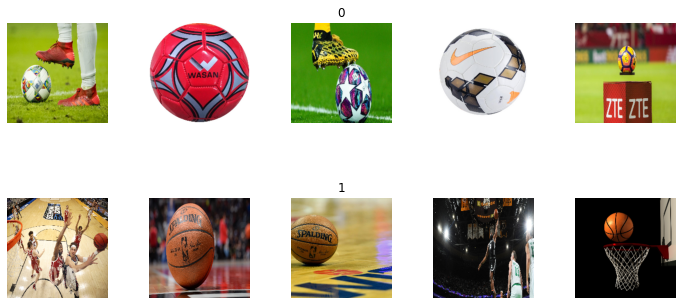

In [15]:
# display both negative and postive classes of images

num_of_samples=[]
num_classes = 2
cols = 5
labels = [0,1]

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(10,5))
fig.tight_layout()
y_data = np.argmax(y_train , axis=-1)
 
for i in range(cols):
    for j in labels:
      x_selected = X_train[y_data == j]
      rimg = x_selected[random.randint(0,(len(x_selected) - 1)), :, :]
      axs[j][i].imshow(cv2.cvtColor(rimg, cv2.COLOR_BGR2RGB))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j))
        num_of_samples.append(len(x_selected))
print(num_of_samples)

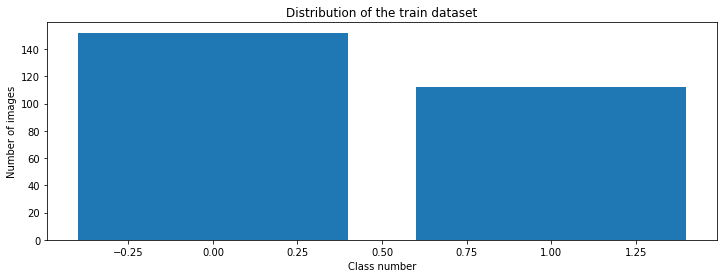

In [16]:
# distribution of classes in the train dataset

plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [20]:
X_train.shape

(264, 224, 224, 3)

In [21]:
# augmenting images using data generator

from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.4,
                            shear_range=0.2,
                            rotation_range=10., rescale = 1./255)
datagen_val = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.4,
                            shear_range=0.2,
                            rotation_range=10., rescale = 1./255)
 
datagen.fit(X_train)
datagen_val.fit(X_val)

In [22]:
# intialising the model

def modified_model(): 
  model=keras.models.Sequential([
      keras.layers.Conv2D(filters=512, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPool2D(pool_size=(2,2)),

      keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="valid"),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPool2D(pool_size=(3,3)),

      keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="valid"),
      keras.layers.BatchNormalization(),

      keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="valid"),
      keras.layers.BatchNormalization(),

      keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="valid"),
      keras.layers.BatchNormalization(),

      keras.layers.MaxPool2D(pool_size=(2,2)),

      keras.layers.Flatten(),
      keras.layers.Dense(2948,activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1024,activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1024,activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(2,activation='softmax')
  ])
  model.compile(Adam(0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
  return model

In [23]:
# model summary

model = modified_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 512)       186368    
_________________________________________________________________
batch_normalization (BatchNo (None, 54, 54, 512)       2048      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 256)       3277056   
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 256)         5

In [24]:
# running model for 50 epochs

history = model.fit(datagen.flow(X_train, y_train, batch_size=50),
                               validation_data=datagen_val.flow(X_val, y_val, batch_size=50),
                               epochs= 50, 
                               shuffle = 1, 
                               verbose =1)

Epoch 1/50
6/6 [==============================] - 97s 13s/step - loss: 1.1612 - accuracy: 0.5247 - val_loss: 0.6889 - val_accuracy: 0.5000
Epoch 2/50
6/6 [==============================] - 77s 12s/step - loss: 0.9059 - accuracy: 0.6318 - val_loss: 0.6865 - val_accuracy: 0.7368
Epoch 3/50
6/6 [==============================] - 77s 13s/step - loss: 0.8026 - accuracy: 0.6290 - val_loss: 0.6871 - val_accuracy: 0.7632
Epoch 4/50
6/6 [==============================] - 77s 12s/step - loss: 0.4986 - accuracy: 0.7799 - val_loss: 0.6897 - val_accuracy: 0.5263
Epoch 5/50
6/6 [==============================] - 80s 13s/step - loss: 0.4842 - accuracy: 0.7916 - val_loss: 0.6892 - val_accuracy: 0.5000
Epoch 6/50
6/6 [==============================] - 76s 12s/step - loss: 0.4847 - accuracy: 0.8143 - val_loss: 0.6880 - val_accuracy: 0.5000
Epoch 7/50
6/6 [==============================] - 77s 12s/step - loss: 0.4953 - accuracy: 0.7979 - val_loss: 0.6863 - val_accuracy: 0.5263
Epoch 8/50
6/6 [===========

In [25]:
#@title
# Helper Functions for Learning Curve and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'Val'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [26]:
# saving the trained model

!pip install -q pyyaml h5py
!mkdir -p saved_model
model.save('saved_model/alexnet_model')
!zip -r /content/alexnet_night.zip /content/saved_model/alexnet_night

INFO:tensorflow:Assets written to: saved_model/alexnet_night/assets
  adding: content/saved_model/alexnet_night/ (stored 0%)
  adding: content/saved_model/alexnet_night/variables/ (stored 0%)
  adding: content/saved_model/alexnet_night/variables/variables.index (deflated 74%)
  adding: content/saved_model/alexnet_night/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/saved_model/alexnet_night/keras_metadata.pb (deflated 94%)
  adding: content/saved_model/alexnet_night/assets/ (stored 0%)
  adding: content/saved_model/alexnet_night/saved_model.pb (deflated 90%)


In [27]:
# uploading the model

from google.colab import files
files.download('alexnet_night.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

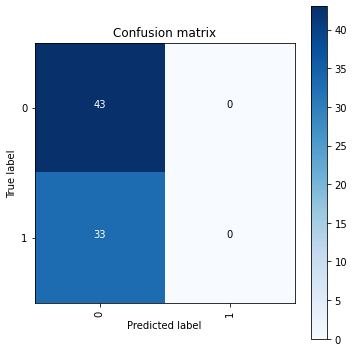

In [28]:
# confusion matrix

y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(labels))

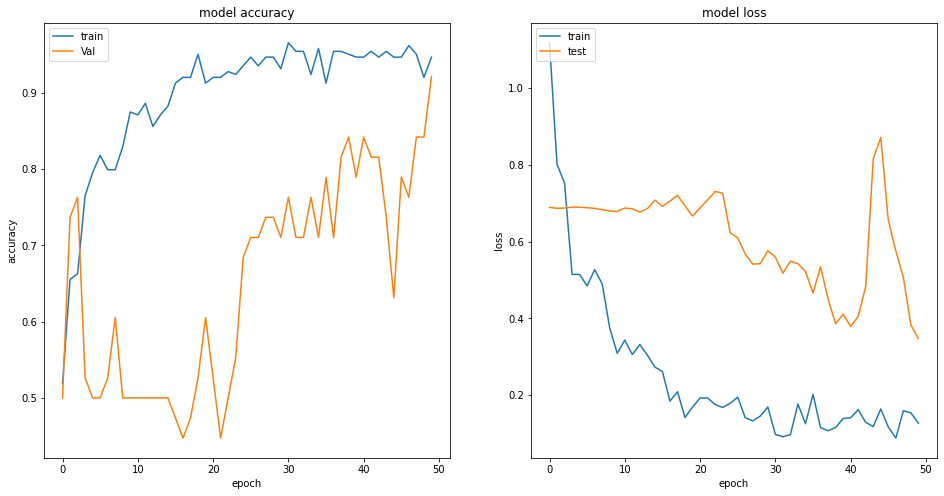

In [29]:
plot_learning_curve(history)

In [30]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.57      1.00      0.72        43
           1       0.00      0.00      0.00        33

    accuracy                           0.57        76
   macro avg       0.28      0.50      0.36        76
weighted avg       0.32      0.57      0.41        76



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
# evaluate model on test data

score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 516.977294921875
Test accuracy: 0.5657894611358643


(224, 224, 3)
predicted sign: [0]


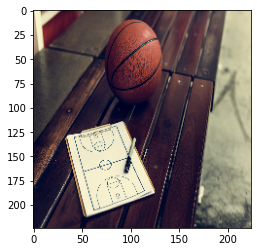

In [32]:
# checking model ouput for postive class

import requests
from PIL import Image
url = 'https://onlinebasketballcoach.com/wp-content/uploads/revslider/gym1/basketball-sport-athletic-activity-game-skill-19201.jpg?v=1'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
img = np.asarray(img)
img = cv2.resize(img, (224, 224))
# img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 224, 224, 3)

print("predicted sign: "+ str(np.argmax(model.predict(img), axis=-1)))

(1064, 1260, 3)
(224, 224, 3)
predicted sign: [0]


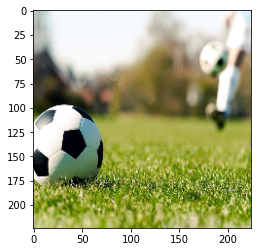

In [33]:
# checking model ouput for negative class

import requests
from PIL import Image
url = 'https://ugc.futurelearn.com/uploads/images/2b/7f/header_2b7fa9a2-6988-438f-a468-465e8964bf26.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
img = np.asarray(img)
print(img.shape)
img = cv2.resize(img, (224, 224))
# img = preprocess(img)
plt.imshow(img)
print(img.shape)
img = img.reshape(1, 224, 224, 3)

print("predicted sign: "+ str(np.argmax(model.predict(img), axis=-1)))